In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import binom
import pandas as pd
from itertools import accumulate

sim2

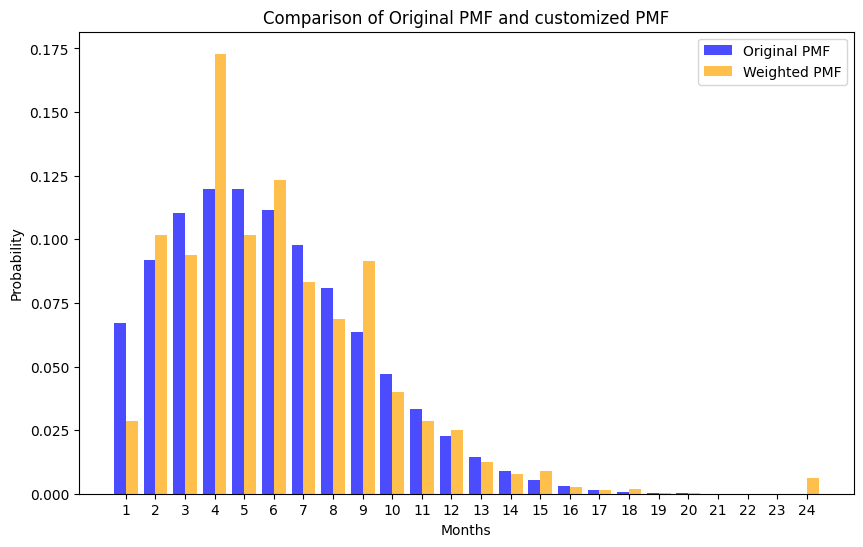

In [4]:
number_of_months = 24
x = np.arange(1, number_of_months + 1)
pmf = binom.pmf(x, number_of_months, 0.2)
pmf = pmf**0.3/(pmf**0.3).sum()

# Define weights based on examination
weights = np.ones_like(pmf)
weights_ultrasound = np.zeros_like(pmf)
weights_PET = np.zeros_like(pmf)

weights_ultrasound[[1,5,11,14,17,20]] = 0.3
weights_PET[[3,8,23]] = 0.7

#some extra customization
weights += weights_ultrasound + weights_PET
weights[-1] = 4000
weights[14] = 2
weights[17] = 3
weights[0] = 0.5

# Apply weights to the PMF
weighted_pmf = pmf * weights

# Normalize the weighted PMF
weighted_pmf /= np.sum(weighted_pmf)

# Plot the original PMF and weighted PMF
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, pmf, width=0.4, label='Original PMF', color='blue', alpha=0.7)
plt.bar(x + 0.2, weighted_pmf, width=0.4, label='Weighted PMF', color='orange', alpha=0.7)
plt.xlabel('Months')
plt.ylabel('Probability')
plt.xticks(x)
plt.title('Comparison of Original PMF and customized PMF')
plt.legend()
plt.show()

In [47]:
def interim_evaluator(patient_true_status,patient_actual_status,patients_time_count,recessive_patients_diagnose_time,minimum_follow_up, minimum_patients = None,p_interim = 0.10):
    patients_to_consider = (patients_time_count > minimum_follow_up).sum()
    stopp_trial_observed_after_break = 0
    additional_months = 0
    if patients_to_consider == 0:
        return np.array([0, 0, 0])
    while patients_to_consider < minimum_patients and minimum_patients != None:
        patients_time_count += 1
        additional_months += 1
        for recruited_patient_index in range(0,len(patient_true_status)):
            #update the observed status of the patients
            if patient_true_status[recruited_patient_index] == 1:
                if recessive_patients_diagnose_time[recruited_patient_index] < patients_time_count[recruited_patient_index]:
                    patient_actual_status[recruited_patient_index] = 1
        patients_to_consider = (patients_time_count > minimum_follow_up).sum()
    upper_limit_under_p = binom.ppf(0.90, patients_to_consider, p_interim)
    stopp_trial_true = 1 if sum(patient_true_status[:patients_to_consider]) >= upper_limit_under_p else 0
    stopp_trial_observed = 1 if sum(patient_actual_status[:patients_to_consider]) >= upper_limit_under_p else 0
    if stopp_trial_observed == 1:
        patients_time_count += 6
        additional_months += 6 #careful, this changes how additional months behaves!
        for recruited_patient_index in range(0,len(patient_true_status)):
            #update the observed status of the patients
            if patient_true_status[recruited_patient_index] == 1:
                if recessive_patients_diagnose_time[recruited_patient_index] < patients_time_count[recruited_patient_index]:
                    patient_actual_status[recruited_patient_index] = 1
        upper_limit_under_p_after_pause = binom.ppf(0.95, len(patient_true_status), p_interim)
        stopp_trial_observed_after_break = 1 if sum(patient_actual_status) >= upper_limit_under_p_after_pause else 0
    
    return np.array([stopp_trial_true, stopp_trial_observed, patients_to_consider]), additional_months, stopp_trial_observed_after_break
def rate_sampler(month):
    rate_change = [5,9,13,17]
    rate_index = 4 - (np.array(rate_change) > month).sum()
    if rate_index == 0:
        sample = np.round(np.random.normal(2,2/3,1))
        sample = np.clip(sample,0,4)
    elif rate_index == 1:
        sample = np.round(np.random.normal(3,2/3,1))
        sample = np.clip(sample,0,7)
    elif rate_index == 2:
        sample = np.round(np.random.normal(5,4/6,1))
        sample = np.clip(sample,0,8)
    elif rate_index == 3:
        sample = np.round(np.random.normal(6, 4/6, 1))
        sample = np.clip(sample, 0, 8)
    elif rate_index >= 4:
        sample = np.round(np.random.normal(7, 4/6, 1))
        sample = np.clip(sample, 0, 10)
    return sample

def sample_custom_pmf(size=1):
    x = np.arange(1, 24 + 1)
    pmf = binom.pmf(x, 24, 0.2)
    pmf = pmf**0.3/(pmf**0.3).sum()

    # Define weights based on examination
    weights = np.ones_like(pmf)
    weights_ultrasound = np.zeros_like(pmf)
    weights_PET = np.zeros_like(pmf)

    weights_ultrasound[[1,5,11,14,17,20]] = 0.3
    weights_PET[[3,8,23]] = 0.7

    #some extra customization
    weights += weights_ultrasound + weights_PET
    weights[-1] = 4000
    weights[14] = 2
    weights[17] = 3
    weights[0] = 0.5

    # pmf = binom.pmf(x, 24, 0.32)
    # pmf = pmf**0.3/(pmf**0.3).sum()

    # # Define weights based on examination
    # weights = np.ones_like(pmf)
    # weights_ultrasound = np.zeros_like(pmf)
    # weights_PET = np.zeros_like(pmf)

    # weights_ultrasound[[1,5,11,14,17,20]] = 0.3
    # weights_PET[[3,8,23]] = 1

    # #some extra customization
    # weights += weights_ultrasound + weights_PET
    # weights[-1] = 300
    # weights[14] = 2
    # weights[17] = 3
    # weights[0] = 0.5

    # Apply weights to the PMF
    weighted_pmf = pmf * weights

    # Normalize the weighted PMF
    weighted_pmf /= np.sum(weighted_pmf)
    cdf = list(accumulate(weighted_pmf))
    return np.searchsorted(cdf, np.random.rand(size))+1

def recruitement_evaluator_Jan(recruitement_condition = None, total_number_pat = 120, p0 = 0.1, interim = None, minimum_follow_up = 6, minimum_patients = None, p_interim = None):
    if recruitement_condition > total_number_pat:
        print('recruitement_condition must be lower or equal to total_number_pat. condition has been set to total_number_pat')
        recruitement_condition = total_number_pat
    if interim != None:
        interim_analyses = np.zeros((len(interim),3))
    else: 
        interim_analyses = 0
    interim_looper = 0
    recruitement_list = np.zeros((total_number_pat,1))
    patients_time_count = np.zeros((total_number_pat,1))
    patient_true_status = np.zeros((total_number_pat,1))
    patient_observed_status = np.zeros((total_number_pat,1))
    recessive_patients_diagnose_time = np.zeros((total_number_pat,1))
    recruitement_month = np.zeros((total_number_pat,1))
    patient_index = 0 #index of actual patient to be recruited
    month = 1
    while patient_index < recruitement_condition:
        # update the already recruited patients
        patients_time_count[:patient_index] += 1
        for recruited_patient_index in range(0,patient_index):
            #update the observed status of the patients
            if patient_true_status[recruited_patient_index] == 1:
                if recessive_patients_diagnose_time[recruited_patient_index] == patients_time_count[recruited_patient_index]:
                    patient_observed_status[recruited_patient_index] = 1
        # recruite new patients
        if patient_index < total_number_pat:
            number_of_new_patients = int(rate_sampler(month)[0])
            if number_of_new_patients > (recruitement_condition)-patient_index:
                number_of_new_patients = (recruitement_condition)-patient_index
            for k in range(0,number_of_new_patients):
                patient_true_status[patient_index] = 0 if random.uniform(0,1) > p0 else 1
                recruitement_list[patient_index] = 1
                recruitement_month[patient_index] = month
                if patient_true_status[patient_index] == 1:
                    recessive_patients_diagnose_time[patient_index] = 1
                    # int(sample_custom_pmf(size = 1)[0]) + 2 #add two months additional time between recruting and actual treatment end
                patient_index += 1 
        if (interim != None) and (recruitement_list.sum() >= interim[interim_looper]):
            interim_analyses[interim_looper], additional_months, stop_after_break = interim_evaluator(patient_true_status[:interim[interim_looper]].copy(),patient_observed_status[:interim[interim_looper]].copy(),patients_time_count[:interim[interim_looper]].copy(),recessive_patients_diagnose_time[:interim[interim_looper]].copy(), minimum_follow_up, minimum_patients, p_interim[interim_looper])
            interim_looper += 1
            patients_time_count[:patient_index] += additional_months
            month += additional_months
            #update the observed status of the patients at the end
            for recruited_patient_index in range(0,patient_index):
                if patient_true_status[recruited_patient_index] == 1:
                    if recessive_patients_diagnose_time[recruited_patient_index] < patients_time_count[recruited_patient_index]:
                        patient_observed_status[recruited_patient_index] = 1     
        month += 1     

    concatenated_data = np.concatenate((recruitement_list,recruitement_month, patients_time_count,patient_true_status, patient_observed_status, recessive_patients_diagnose_time), axis=1)
    df = pd.DataFrame(concatenated_data, columns=['Recruitement status','Month of recruitement', 'Months since recruitement', 'True recessive status', 'Observed status', 'diagnose time after treatment'])
    return df, month, interim_analyses, additional_months, stop_after_break


In [48]:
df, month, interim_analyses, additional_months, stop_after_break = recruitement_evaluator_Jan(recruitement_condition= 61, total_number_pat = 120, p0 = 0.30,interim=[60,120], minimum_follow_up=8, minimum_patients= 20,p_interim = [0.10,0.10])
# print(month)
stop_after_break
additional_months


8

In [49]:
interim_analyses

array([[ 1.,  1., 24.],
       [ 0.,  0.,  0.]])

In [50]:
df[0:60]

,Recruitement status,Month of recruitement,Months since recruitement,True recessive status,Observed status,diagnose time after treatment
0,1.0,1.0,23.0,1.0,1.0,1.0
1,1.0,1.0,23.0,0.0,0.0,0.0
2,1.0,2.0,22.0,1.0,1.0,1.0
3,1.0,2.0,22.0,0.0,0.0,0.0
4,1.0,3.0,21.0,1.0,1.0,1.0
5,1.0,4.0,20.0,0.0,0.0,0.0
6,1.0,4.0,20.0,0.0,0.0,0.0
7,1.0,5.0,19.0,0.0,0.0,0.0
8,1.0,5.0,19.0,0.0,0.0,0.0
9,1.0,5.0,19.0,0.0,0.0,0.0


In [54]:
number_of_simulations = 10000
stopping_array_looper = np.zeros((number_of_simulations,2))
patients_at_interim = [60,120]
interim_at_60 = np.zeros((number_of_simulations,4))
interim_at_120 = np.zeros((number_of_simulations,4))
break_stopper = np.zeros(number_of_simulations)
p0 = 0.10
p_interim = [0.10,0.10]
minimum_patients = 20
minimum_follow_up = 6 
minimum_follow_up = minimum_follow_up + 2 #add two months as we want to consider the time delay between recruiting and treatment end
for i in range(0,number_of_simulations):
    df_looper, month_looper, interim_analyses_looper, additional_months_looper, stop_after_break_looper = recruitement_evaluator_Jan(recruitement_condition= 70, total_number_pat = 120, p0 = p0,interim=patients_at_interim, minimum_follow_up= minimum_follow_up, minimum_patients= minimum_patients,p_interim = p_interim)
    interim_at_60[i,:3] = interim_analyses_looper[0]
    interim_at_60[i,-1] = additional_months_looper
    interim_at_120[i,:3] = interim_analyses_looper[1]
    break_stopper[i] = stop_after_break_looper



In [55]:
print('under ', p0*100, '%')
print('at first interim we have on average',interim_at_60[:,-2].mean(), 'patients to be included after waiting', interim_at_60[:,-1].mean(), 'months')
print('We would stop in', interim_at_60[:,[1]].sum()/number_of_simulations*100, '% of first analysis' )
print('We would stop in ', break_stopper.sum()/interim_at_60[:,[1]].sum() * 100, '% of cases after break')
print('We would stop in', interim_at_120[:,[1]].sum()/number_of_simulations*100, '% of  second analysis' )
print('if events were instantaneous we would stop in', interim_at_60[:,[0]].sum()/number_of_simulations*100, '% of first analysis' )
print('if events were instantaneous we would stop in', interim_at_120[:,[0]].sum()/number_of_simulations*100, '% of  second analysis' )

under  10.0 %
at first interim we have on average 21.764266666666668 patients to be included after waiting 2.5582666666666665 months
We would stop in 16.7 % of first analysis
We would stop in  26.506986027944112 % of cases after break
We would stop in 0.0 % of  second analysis
if events were instantaneous we would stop in 16.7 % of first analysis
if events were instantaneous we would stop in 0.0 % of  second analysis


In [56]:
0.167*0.265

0.044255

: 

In [46]:
print('under ', p0*100, '%')
print('at first interim we have on average',interim_at_60[:,-2].mean(), 'patients to be included after waiting', interim_at_60[:,-1].mean(), 'months')
print('We would stop in', interim_at_60[:,[1]].sum()/number_of_simulations*100, '% of first analysis' )
print('We would stop in ', break_stopper.sum()/interim_at_60[:,[1]].sum() * 100, '% of cases after break')
print('We would stop in', interim_at_120[:,[1]].sum()/number_of_simulations*100, '% of  second analysis' )
print('if events were instantaneous we would stop in', interim_at_60[:,[0]].sum()/number_of_simulations*100, '% of first analysis' )
print('if events were instantaneous we would stop in', interim_at_120[:,[0]].sum()/number_of_simulations*100, '% of  second analysis' )

under  15.0 %
at first interim we have on average 21.7572 patients to be included after waiting 3.1631 months
We would stop in 26.91 % of first analysis
We would stop in  47.4544778892605 % of cases after break
We would stop in 0.0 % of  second analysis
if events were instantaneous we would stop in 41.17 % of first analysis
if events were instantaneous we would stop in 0.0 % of  second analysis


## with second stopping rule

In [11]:
def interim_evaluator(patient_true_status,patient_actual_status,patients_time_count,recessive_patients_diagnose_time,minimum_follow_up, minimum_patients = None,p_interim = 0.10):
    patients_to_consider = (patients_time_count > minimum_follow_up).sum()
    stopp_trial_observed_after_break = 0
    additional_months = 0
    if patients_to_consider == 0:
        return np.array([0, 0, 0])
    while patients_to_consider < minimum_patients and minimum_patients != None:
        # print(patients_to_consider)
        patients_time_count += 1
        additional_months += 1
        for recruited_patient_index in range(0,len(patient_true_status)):
            #update the observed status of the patients
            if patient_true_status[recruited_patient_index] == 1:
                if recessive_patients_diagnose_time[recruited_patient_index] < patients_time_count[recruited_patient_index]:
                    patient_actual_status[recruited_patient_index] = 1
        patients_to_consider = (patients_time_count > minimum_follow_up).sum()
    upper_limit_under_p = binom.ppf(0.90, patients_to_consider, p_interim)
    stopp_trial_true = 1 if sum(patient_true_status[:patients_to_consider]) >= upper_limit_under_p else 0
    stopp_trial_observed = 1 if sum(patient_actual_status[:patients_to_consider]) >= upper_limit_under_p else 0
    if stopp_trial_observed == 1:
        patients_time_count += 6
        additional_months += 6
        for recruited_patient_index in range(0,len(patient_true_status)):
            #update the observed status of the patients
            if patient_true_status[recruited_patient_index] == 1:
                if recessive_patients_diagnose_time[recruited_patient_index] < patients_time_count[recruited_patient_index]:
                    patient_actual_status[recruited_patient_index] = 1
        upper_limit_under_p_after_pause = binom.ppf(0.95, len(patient_true_status), p_interim)
        stopp_trial_observed_after_break = 1 if sum(patient_actual_status) >= upper_limit_under_p_after_pause else 0
    
    return np.array([stopp_trial_true, stopp_trial_observed, patients_to_consider]), additional_months, stopp_trial_observed_after_break
def rate_sampler(month):
    rate_change = [5,9,13,17]
    rate_index = 4 - (np.array(rate_change) > month).sum()
    if rate_index == 0:
        sample = np.round(np.random.normal(2,2/3,1))
        sample = np.clip(sample,0,4)
    elif rate_index == 1:
        sample = np.round(np.random.normal(3,2/3,1))
        sample = np.clip(sample,0,7)
    elif rate_index == 2:
        sample = np.round(np.random.normal(5,4/6,1))
        sample = np.clip(sample,0,8)
    elif rate_index == 3:
        sample = np.round(np.random.normal(6, 4/6, 1))
        sample = np.clip(sample, 0, 8)
    elif rate_index >= 4:
        sample = np.round(np.random.normal(7, 4/6, 1))
        sample = np.clip(sample, 0, 10)
    return sample

def sample_custom_pmf(size=1):
    x = np.arange(1, 24 + 1)
    pmf = binom.pmf(x, 24, 0.32)
    pmf = pmf**0.3/(pmf**0.3).sum()

    # Define weights based on examination
    weights = np.ones_like(pmf)
    weights_ultrasound = np.zeros_like(pmf)
    weights_PET = np.zeros_like(pmf)

    weights_ultrasound[[1,5,11,14,17,20]] = 0.3
    weights_PET[[3,8,23]] = 1

    #some extra customization
    weights += weights_ultrasound + weights_PET
    weights[-1] = 300
    weights[14] = 2
    weights[17] = 3
    weights[0] = 0.5

    # Apply weights to the PMF
    weighted_pmf = pmf * weights

    # Normalize the weighted PMF
    weighted_pmf /= np.sum(weighted_pmf)
    cdf = list(accumulate(weighted_pmf))
    return np.searchsorted(cdf, np.random.rand(size))+1

def recruitement_evaluator_Jan2(recruitement_condition = None, total_number_pat = 120, p0 = 0.1, interim = None, minimum_follow_up = 6, minimum_patients = None, p_interim = None, max_events = None):
    if recruitement_condition > total_number_pat:
        print('recruitement_condition must be lower or equal to total_number_pat. condition has been set to total_number_pat')
        recruitement_condition = total_number_pat
    if interim != None:
        interim_analyses = np.zeros((len(interim),3))
    else: 
        interim_analyses = 0
    interim_looper = 0
    recruitement_list = np.zeros((total_number_pat,1))
    patients_time_count = np.zeros((total_number_pat,1))
    patient_true_status = np.zeros((total_number_pat,1))
    patient_observed_status = np.zeros((total_number_pat,1))
    recessive_patients_diagnose_time = np.zeros((total_number_pat,1))
    recruitement_month = np.zeros((total_number_pat,1))
    patient_index = 0 #index of actual patient to be recruited
    month = 1
    stopping_month = 10000000
    number_of_recruited_patients = 0
    additional_months = 0
    stop_after_break = 0
    while patient_index < recruitement_condition:
        # update the already recruited patients
        patients_time_count[:patient_index] += 1
        for recruited_patient_index in range(0,patient_index):
            #update the observed status of the patients
            if patient_true_status[recruited_patient_index] == 1:
                if recessive_patients_diagnose_time[recruited_patient_index] == patients_time_count[recruited_patient_index]:
                    patient_observed_status[recruited_patient_index] = 1
        #we stop if we surpass max events
        if patient_observed_status.sum() >= max_events:
            print('stopped due to max events')
            stopping_month = month
            number_of_recruited_patients = recruitement_list.sum()
            concatenated_data = np.concatenate((recruitement_list,recruitement_month, patients_time_count,patient_true_status, patient_observed_status, recessive_patients_diagnose_time), axis=1)
            df = pd.DataFrame(concatenated_data, columns=['Recruitement status','Month of recruitement', 'Months since recruitement', 'True recessive status', 'Observed status', 'diagnose time after treatment'])
            return df, month, interim_analyses, additional_months, stop_after_break, stopping_month, number_of_recruited_patients

        # recruite new patients
        if patient_index < total_number_pat:
            number_of_new_patients = int(rate_sampler(month)[0])
            if number_of_new_patients > (recruitement_condition)-patient_index:
                number_of_new_patients = (recruitement_condition)-patient_index
            for k in range(0,number_of_new_patients):
                patient_true_status[patient_index] = 0 if random.uniform(0,1) > p0 else 1
                recruitement_list[patient_index] = 1
                recruitement_month[patient_index] = month
                if patient_true_status[patient_index] == 1:
                    recessive_patients_diagnose_time[patient_index] = int(sample_custom_pmf(size = 1)[0]) + 2 #add two months additional time between recruting and actual treatment end
                patient_index += 1 
        if (interim != None) and (recruitement_list.sum() >= interim[interim_looper]):
            interim_analyses[interim_looper], additional_months, stop_after_break = interim_evaluator(patient_true_status[:interim[interim_looper]].copy(),patient_observed_status[:interim[interim_looper]].copy(),patients_time_count[:interim[interim_looper]].copy(),recessive_patients_diagnose_time[:interim[interim_looper]].copy(), minimum_follow_up, minimum_patients, p_interim[interim_looper])
            interim_looper += 1
            patients_time_count[:patient_index] += additional_months
            month += additional_months
            #update the observed status of the patients at the end
            for recruited_patient_index in range(0,patient_index):
                if patient_true_status[recruited_patient_index] == 1:
                    if recessive_patients_diagnose_time[recruited_patient_index] < patients_time_count[recruited_patient_index]:
                        patient_observed_status[recruited_patient_index] = 1     
            if stop_after_break == 1:
                concatenated_data = np.concatenate((recruitement_list,recruitement_month, patients_time_count,patient_true_status, patient_observed_status, recessive_patients_diagnose_time), axis=1)
                df = pd.DataFrame(concatenated_data, columns=['Recruitement status','Month of recruitement', 'Months since recruitement', 'True recessive status', 'Observed status', 'diagnose time after treatment'])
                return df, month, interim_analyses, additional_months, stop_after_break, stopping_month, number_of_recruited_patients
        month += 1     

    concatenated_data = np.concatenate((recruitement_list,recruitement_month, patients_time_count,patient_true_status, patient_observed_status, recessive_patients_diagnose_time), axis=1)
    df = pd.DataFrame(concatenated_data, columns=['Recruitement status','Month of recruitement', 'Months since recruitement', 'True recessive status', 'Observed status', 'diagnose time after treatment'])
    return df, month, interim_analyses, additional_months, stop_after_break, stopping_month, number_of_recruited_patients


In [12]:
df, month, interim_analyses, additional_months, stop_after_break, stopping_month, number_of_recruited_patients = recruitement_evaluator_Jan2(recruitement_condition= 120, total_number_pat = 120, p0 = 0.30,interim=[60,120], minimum_follow_up=8, minimum_patients= 25,p_interim = [0.10,0.10], max_events = 18)
print(number_of_recruited_patients)
stopping_month


0


10000000

In [13]:
df['Recruitement status'].sum()

64.0

In [14]:
df[0:60]

,Recruitement status,Month of recruitement,Months since recruitement,True recessive status,Observed status,diagnose time after treatment
0,1.0,1.0,24.0,1.0,1.0,8.0
1,1.0,1.0,24.0,0.0,0.0,0.0
2,1.0,2.0,23.0,0.0,0.0,0.0
3,1.0,2.0,23.0,0.0,0.0,0.0
4,1.0,3.0,22.0,1.0,1.0,6.0
5,1.0,4.0,21.0,0.0,0.0,0.0
6,1.0,4.0,21.0,0.0,0.0,0.0
7,1.0,5.0,20.0,1.0,1.0,6.0
8,1.0,5.0,20.0,0.0,0.0,0.0
9,1.0,5.0,20.0,0.0,0.0,0.0


In [15]:
number_of_simulations = 10000
stopping_array_looper = np.zeros((number_of_simulations,2))
patients_at_interim = [60,120]
interim_at_60 = np.zeros((number_of_simulations,4))
interim_at_120 = np.zeros((number_of_simulations,4))
break_stopper_array = np.zeros(number_of_simulations)
stopping_month_array = np.zeros(number_of_simulations)
number_of_recruited_patients_array = np.zeros(number_of_simulations)
p0 = 0.20
p_interim = [0.10,0.10]
minimum_patients = 20
minimum_follow_up = 6 
max_events = 18
minimum_follow_up = minimum_follow_up + 2 #add two months as we want to consider the time delay between recruiting and treatment end
for i in range(0,number_of_simulations):
    df_looper, month_looper, interim_analyses_looper, additional_months_looper, stop_after_break_looper, stopping_month_looper, number_of_recruited_patients_looper = recruitement_evaluator_Jan2(recruitement_condition= 70, total_number_pat = 120, p0 = p0,interim=patients_at_interim, minimum_follow_up= minimum_follow_up, minimum_patients= minimum_patients,p_interim = p_interim,max_events = max_events)
    interim_at_60[i,:3] = interim_analyses_looper[0]
    interim_at_60[i,-1] = additional_months_looper
    interim_at_120[i,:3] = interim_analyses_looper[1]
    break_stopper_array[i] = stop_after_break_looper
    stopping_month_array[i] = stopping_month_looper
    number_of_recruited_patients_array[i] = number_of_recruited_patients_looper



In [16]:
stopping_month_array[stopping_month_array < 1000]

array([], dtype=float64)

In [17]:
break_stopper_array.sum()

1511.0

In [18]:
indices_with_break = interim_at_60[:,1].astype(bool)
break_not_stopped = interim_at_60[:,1].astype(bool) & (break_stopper_array != 1)
total_with_break = interim_at_60[:,1].astype(bool).sum()
stopped_due_to_max = stopping_month_array < 10000
total_stopped_early_with_break = len(stopping_month_array[(stopping_month_array < 1000) & break_not_stopped])
number_of_recruited_patients_when_early = number_of_recruited_patients_array[(stopping_month_array < 10000) & (interim_at_60[:,-1] > 5)].mean()
stopping_month_average = stopping_month_array[(stopping_month_array < 1000) & (interim_at_60[:,-1] > 5)].mean()


C:\Users\yoelh\AppData\Local\Temp\ipykernel_29936\2391432726.py:6: RuntimeWarning: Mean of empty slice.
  number_of_recruited_patients_when_early = number_of_recruited_patients_array[(stopping_month_array < 10000) & (interim_at_60[:,-1] > 5)].mean()
C:\Users\yoelh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\yoelh\AppData\Local\Temp\ipykernel_29936\2391432726.py:7: RuntimeWarning: Mean of empty slice.
  stopping_month_average = stopping_month_array[(stopping_month_array < 1000) & (interim_at_60[:,-1] > 5)].mean()


In [19]:
total_stopped_early_with_break

0

In [20]:
break_stopper_array[stopped_due_to_max]

array([], dtype=float64)

In [21]:
stopping_month_array[break_not_stopped]

array([10000000., 10000000., 10000000., ..., 10000000., 10000000.,
       10000000.])

In [22]:
total_stopped_early_with_break

0

In [23]:
number_of_recruited_patients_array[(interim_at_60[:,-1] > 5)]

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
print('under ', p0*100, '%')
print('We would stop in', interim_at_60[:,[1]].sum()/number_of_simulations*100, '% of first analysis' )
print('We would stop in ', break_stopper_array.sum()/interim_at_60[:,[1]].sum() * 100, '% of cases after break')
print('We would stop in', interim_at_120[:,[1]].sum()/number_of_simulations*100, '% of  second analysis' )
print('If we do not stop after break, we would ')
print('if events were instantaneous we would stop in', interim_at_60[:,[0]].sum()/number_of_simulations*100, '% of first analysis' )


under  20.0 %
We would stop in 28.050000000000004 % of first analysis
We would stop in  53.8680926916221 % of cases after break
We would stop in 0.0 % of  second analysis
If we do not stop after break, we would 
if events were instantaneous we would stop in 65.25999999999999 % of first analysis
